<h1>
<font color="#ff2e2e">
CamScanner
</font>
</h1>

In [187]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

<h3><font color = "#079e05"> Utilities </font></h3>

In [188]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [189]:
def reorder(vertices):
    # OpenCV *prefers* if we use `np.float32`.
    reordered = np.zeros_like(vertices, dtype=np.float32)
    add = vertices.sum(1)
    reordered[0] = vertices[np.argmin(add)]
    reordered[2] = vertices[np.argmax(add)]
    diff = np.diff(vertices, axis=1)
    reordered[1] = vertices[np.argmin(diff)]
    reordered[3] = vertices[np.argmax(diff)]
    return reordered

<h3><font color = "#079e05"> Image </font></h3>

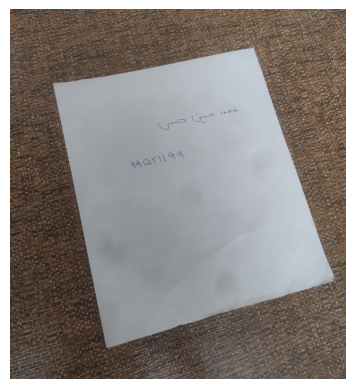

In [190]:
image = cv2.imread(os.path.join('images/Q4', '1.jpg'))
imshow(image)

<h3><font color = "#079e05"> Process </font></h3>

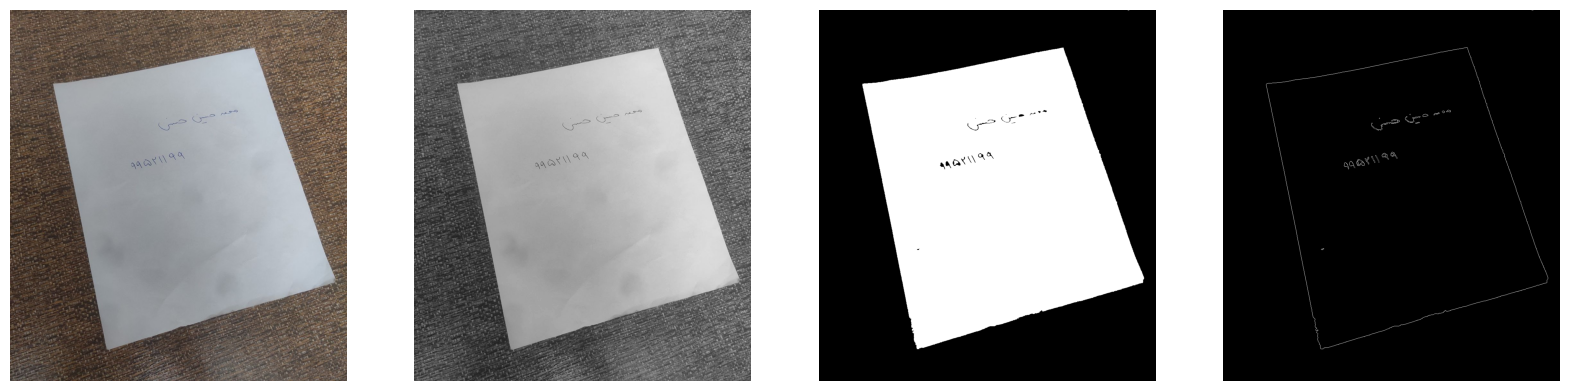

In [191]:
# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply median filter for denoising
denoised_image = cv2.medianBlur(gray_image, 5)

# Apply Gaussian blur
denoised_image = cv2.GaussianBlur(gray_image, (1, 1), 0)

# set value grate than 127 to 255 and less than 127 to 0
ret, thresh = cv2.threshold(denoised_image, 130, 255, cv2.THRESH_BINARY)

# remove noise
kernel = np.ones((5, 5), np.uint8)
thresh = cv2.erode(thresh, kernel, iterations=1)
thresh = cv2.dilate(thresh, kernel, iterations=1)

# remove text and just keep the A4 paper
kernel = np.ones((15, 15), np.uint8)
thresh2 = cv2.erode(thresh, kernel, iterations=1)
thresh2 = cv2.dilate(thresh, kernel, iterations=1)

# Detect edges using the Canny edge detector
edges = cv2.Canny(thresh, 50, 150, apertureSize=3)

# Display the results
plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
imshow(image)
plt.subplot(1, 4, 2)
imshow(denoised_image)
plt.subplot(1, 4, 3)
imshow(thresh)
plt.subplot(1, 4, 4)
imshow(edges)
plt.show()

<h3><font color = "#079e05"> Find contours </font></h3>

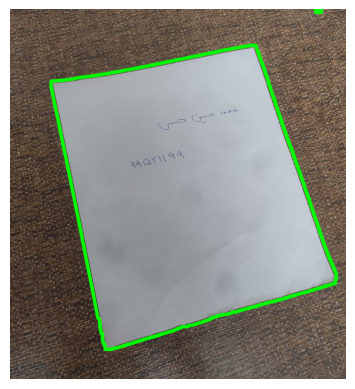

In [192]:
# Find contours in the binary image
contours, hierarchy = cv2.findContours(thresh2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#  Draw contour on copy image
img = image.copy()
cv2.drawContours(img, contours, -1, (0, 255, 0), 10)
imshow(img)

<h3><font color = "#079e05"> Show the result </font></h3>

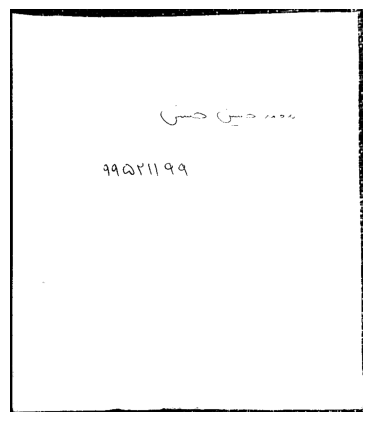

In [184]:
# Find the contour with the largest area (this should be the paper)
paper_contour = max(contours, key=cv2.contourArea)

# Approximate the contour to a polygon with fewer vertices
epsilon = 0.1 * cv2.arcLength(paper_contour, True)
approx = cv2.approxPolyDP(paper_contour, epsilon, True)

vertices = reorder(approx.reshape(4, 2))

# Compute the width and height of the new image
width = max(np.linalg.norm(vertices[0] - vertices[1]), np.linalg.norm(vertices[2] - vertices[3]))
height = max(np.linalg.norm(vertices[0] - vertices[3]), np.linalg.norm(vertices[1] - vertices[2]))

# Compute the perspective transform matrix
M = cv2.getPerspectiveTransform(vertices, np.float32([[0, 0], [width, 0], [width, height], [0, height]]))

# Apply the perspective transformation to the original image
warped = cv2.warpPerspective(image, M, (int(width), int(height)))

# convert to gray and set value grate than 127 to 255 and less than 127 to 0
ret, thresh = cv2.threshold(warped, 127, 255, cv2.THRESH_BINARY)

# convert to gray
gray_image = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
imshow(gray_image)
plt.show()

<h3><font color = "#079e05"> Optional section </font></h3>

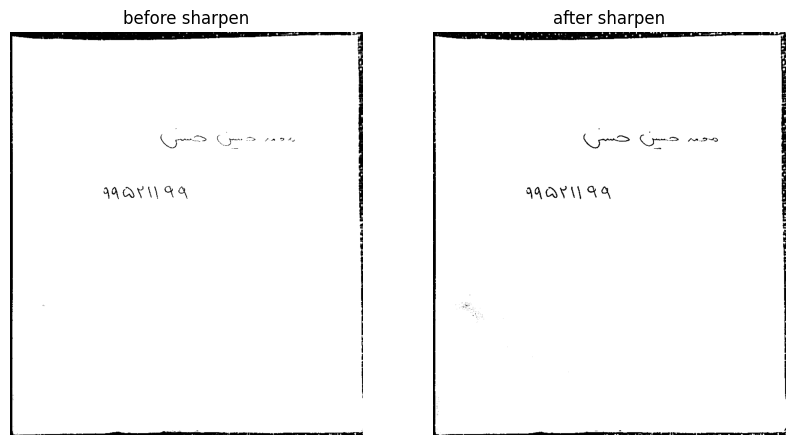

In [185]:
# Apply Gaussian blur to the image
blurred = cv2.GaussianBlur(warped, (5, 5), 0)

# Sharpen the image
kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
sharpened = cv2.filter2D(blurred, -1, kernel)

# convert to gray and set value grate than 127 to 255 and less than 127 to 0
ret, thresh = cv2.threshold(sharpened, 127, 255, cv2.THRESH_BINARY)

# convert to gray
sharpened_gray_image = cv2.cvtColor(thresh, cv2.COLOR_BGR2GRAY)

# Display the results
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('before sharpen')
imshow(gray_image)
plt.subplot(1, 2, 2)
plt.title('after sharpen')
imshow(sharpened_gray_image)
plt.show()